In [138]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import gc
%matplotlib inline 

In [99]:
# read data 
path = "/Users/jiangtao/Documents/GitHub/TalkingData-AdTracking-Fraud-Detection-Challenge/Dataset/"

train = pd.read_csv(path + "train_sample.csv")

In [100]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [101]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
ip                 100000 non-null int64
app                100000 non-null int64
device             100000 non-null int64
os                 100000 non-null int64
channel            100000 non-null int64
click_time         100000 non-null object
attributed_time    227 non-null object
is_attributed      100000 non-null int64
dtypes: int64(6), object(2)
memory usage: 6.1+ MB


In [102]:
# drop attributed_time column as it's not contained in test file 
train.drop("attributed_time", axis=1, inplace=True)

The percentage of unique values are:
[34.857, 0.161, 0.1, 0.13, 0.161],
for ['ip', 'app', 'device', 'os', 'channel'] columns


/Users/jiangtao/miniconda2/envs/py3.5/lib/python3.5/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


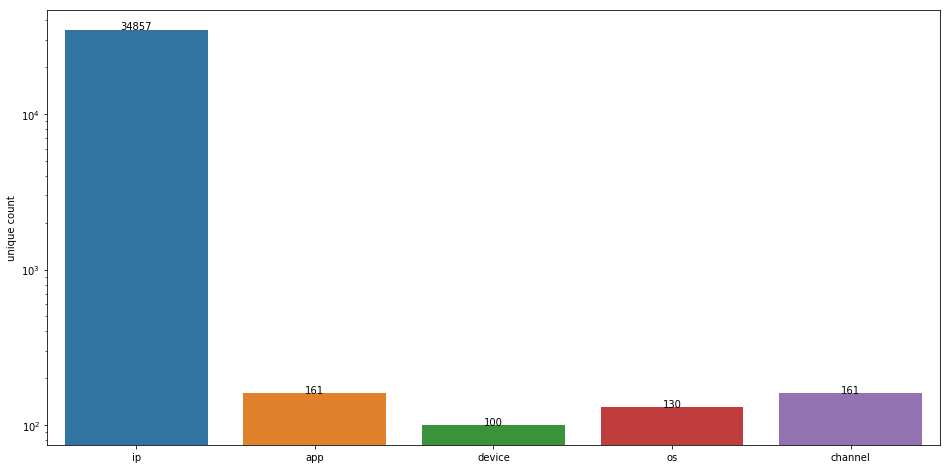

In [103]:
plt.figure(figsize=(16,8))
cols = ["ip", "app", "device", "os", "channel"]
uniques = [train[col].nunique() for col in cols]

ax = sns.barplot(cols, uniques, log=True)
ax.set_ylabel("unique count")

for p, uniq in zip(ax.patches, uniques):
    ax.text(p.get_x() + p.get_width() / 2,
           p.get_height(),
           uniq,
           ha="center")

uniq_ratio = [100 * uniq / len(train) for uniq in uniques]

print("The percentage of unique values are:\n{},\nfor {} columns".format(uniq_ratio, cols))

So the number of unique values for all the features are small compared to dimension of the dataset. 

Let's further check what are the top most frequent values of each feature. 

/Users/jiangtao/miniconda2/envs/py3.5/lib/python3.5/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


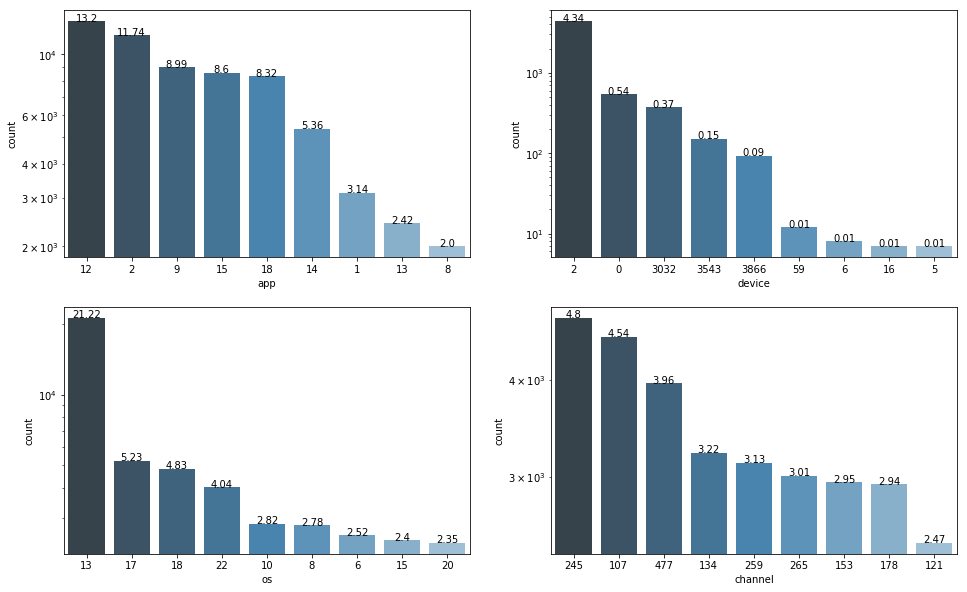

In [104]:
plt.figure(figsize=(16, 10))

for i, col in enumerate(["app","device","os","channel"]):
    counts = pd.value_counts(train[col].values, ascending=False)[1:10]
    indx = counts.index
    counts.reset_index(drop=True, inplace=True)
    
    plt.subplot(2,2,i+1)
    ax = sns.barplot(counts.index, counts.values, log=True, palette="Blues_d")
    ax.set_xticklabels(indx)
    ax.set_xlabel(col)
    ax.set_ylabel("count")
    
    for p, prop in zip(ax.patches, [round(100*val/len(train),2) for val in counts.values]):
        ax.text(p.get_x() + p.get_width() / 2,
               p.get_height(),
               prop,
               ha="center")

Some findings:
* There seems have major app producers, the top 10 producer account for ~50% of the whole market
* Also, there are major device types, probably most recent iphone and some popular Android phones
* Same phenomenon happens in os, assume the most dominant os is IOS or Android

Let's take a look at feature ip now.
Since ip is encoded for safety reason, let's just look at the summary statistics.

In [105]:
train["ip"].describe()

count    100000.000000
mean      91255.879670
std       69835.553661
min           9.000000
25%       40552.000000
50%       79827.000000
75%      118252.000000
max      364757.000000
Name: ip, dtype: float64

/Users/jiangtao/miniconda2/envs/py3.5/lib/python3.5/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


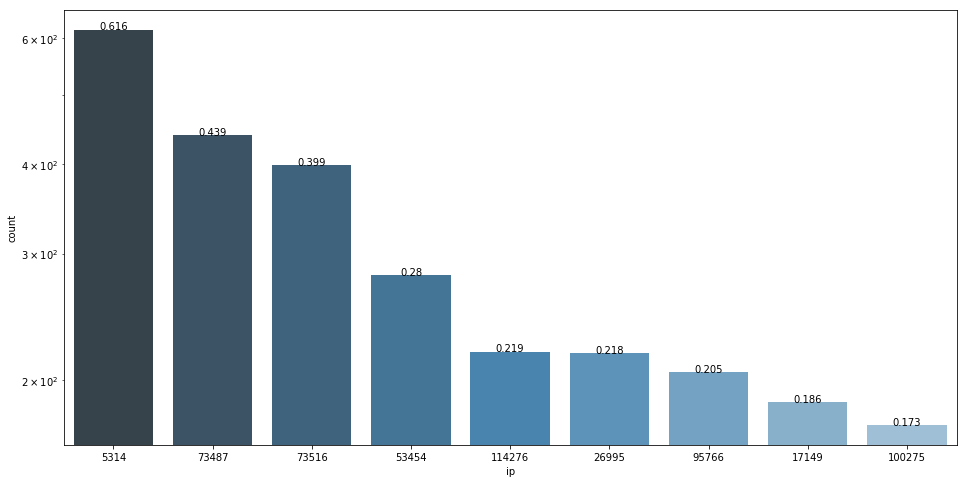

In [109]:
plt.figure(figsize=(16,8))

ip_uniq = pd.value_counts(train["ip"].values, ascending=False)[1:10]
ip_indx = ip_uniq.index
ip_uniq.reset_index(drop=True, inplace=True)

ax = sns.barplot(ip_uniq.index, ip_uniq.values, log=True, palette="Blues_d")
ax.set_xticklabels(ip_indx)
ax.set_xlabel("ip")
ax.set_ylabel("count")

for p, uniq in zip(ax.patches, [round(100*val/len(train), 3) for val in ip_uniq.values]):
    ax.text(p.get_x() + p.get_width() / 2,
           p.get_height(),
           uniq,
           ha="center")   

Also there are major ips that generate quite large amount of the ads clicks. There might be some large network that host all those users. 

As I would imagine, there might be some correlation between these features. For instance: 
* **os** and **device** might be correlated 
* **app** and **channel** might be correlated 

Let's find out the pearson correlation of columns we are interested.

In [110]:
train[cols].corr()

,ip,app,device,os,channel
ip,1.000000,0.010400,-0.001499,-0.000470,0.007563
app,0.010400,1.000000,0.248376,0.247160,-0.028238
device,-0.001499,0.248376,1.000000,0.924456,-0.035398
os,-0.000470,0.247160,0.924456,1.000000,-0.033175
channel,0.007563,-0.028238,-0.035398,-0.033175,1.000000


It looks **os** and **device**, **device** and **app** are somehow correlated, specially the first pair shows strong correlation. 

We haven't check the **click_time** column, let's have a look at it now. We'll extract day and hour from **click_time** column as new features, since: 
* the whole training data is collectd over 4 days 
* hour is pretty good interval to inspect users click behavior, ideally

In [111]:
# extract day and hour from click_time column
# add day and hour as new features
# as we 
day, hour = [], []
for time in train["click_time"]:
    temp = time.split("-")[-1]
    temp = temp.split(":")[0]
    day_tp, hour_tp = temp.split(" ")
    day.append(int(day_tp))
    hour.append(int(hour_tp))

train["day"], train["hour"] = day, hour

Text(0,0.5,'total downloads')

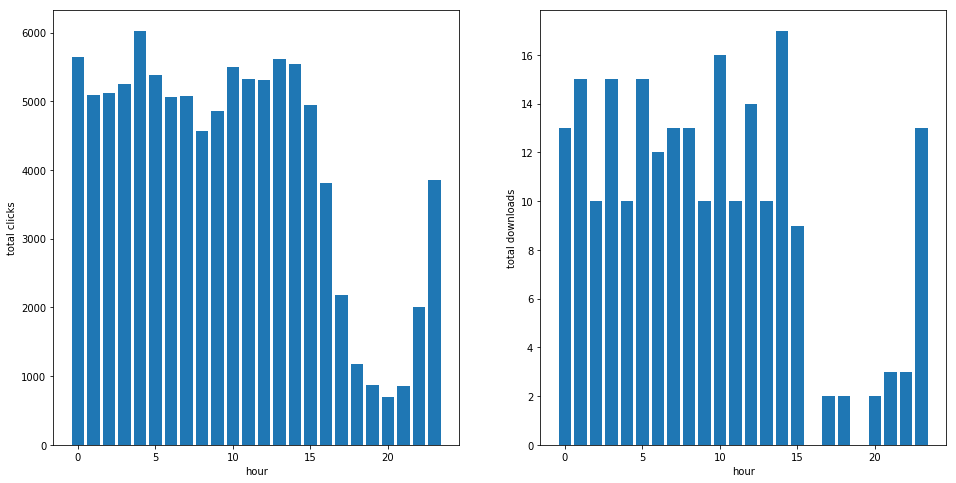

In [137]:
downloads = train.groupby("hour").apply(lambda x: len(x[x.is_attributed == 1]))
clicks = train.groupby("hour").apply(lambda x: len(x[x.is_attributed == 0]))

plt.figure(figsize=(16,8))

plt.subplot(121)
plt.bar(clicks.index, clicks.values)
plt.xlabel("hour")
plt.ylabel("total clicks")

plt.subplot(122)
plt.bar(downloads.index, downloads.values)
plt.xlabel("hour")
plt.ylabel("total downloads")

It looks to me that the **clicks** and **downloads** follow very similar pattern as expected.
* The most inactive hours be around 20:00 
* There are increases in both clicks and downloads after 20:00, and the reach the maximum at 24:00 

Let's plot day-hour clicks/downloads to see if there is repeated trend over days. 

Text(0,0.5,'count for clicks and downloads')

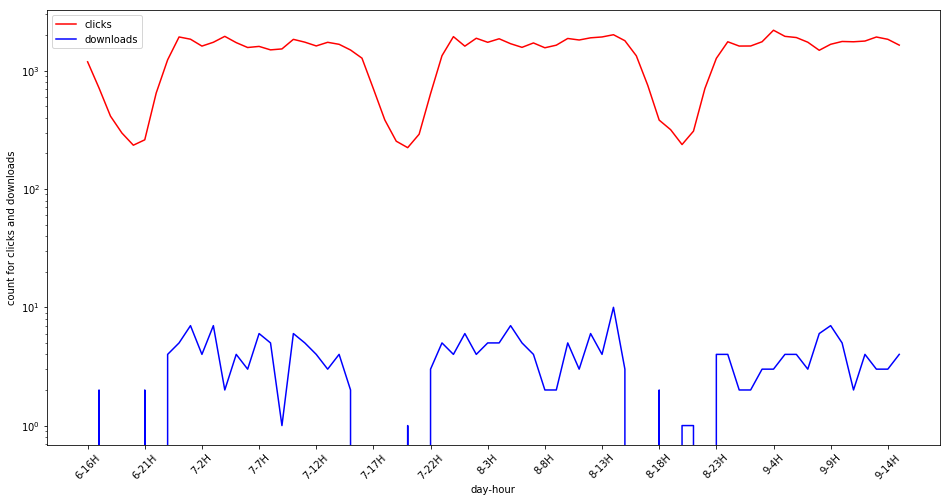

In [278]:
def get_dayHour_data(is_attributed, click):
    temp = train.groupby(["day","hour"]).apply(lambda x: len(x[x.is_attributed == is_attributed]))
    days = temp.index.get_level_values("day")
    hours = temp.index.get_level_values("hour")
    
    dayHour = []
    for day, hour in zip(days, hours):
        
        dayHour.append("-".join([str(day),str(hour) + 'H']))
    
    return pd.DataFrame({"dayHour":dayHour, click:temp.values}, index=np.arange(len(dayHour)))

clickDownload = get_dayHour_data(0,"clicks").merge(get_dayHour_data(1,"downloads"), how="outer", on="dayHour")

plt.figure(figsize=(16,8))

plt.plot(range(len(clickDownload)), clickDownload.clicks, color='red')
plt.plot(range(len(clickDownload)), clickDownload.downloads, color='blue')
plt.yscale("log")
plt.legend()

indx = [i for i in range(0, len(clickDownload), 5)]
plt.xticks([i for i in range(0, len(clickDownload), 5)], 
           clickDownload.dayHour.values[indx],
          rotation=45)

plt.xlabel("day-hour")
plt.ylabel("count for clicks and downloads")

It looks there exist consitent pattern for both **click** and **download** over days. 

Next, let's check how many **downloads** and **clicks**, I'd assume the ratio would be very extreme.

/Users/jiangtao/miniconda2/envs/py3.5/lib/python3.5/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


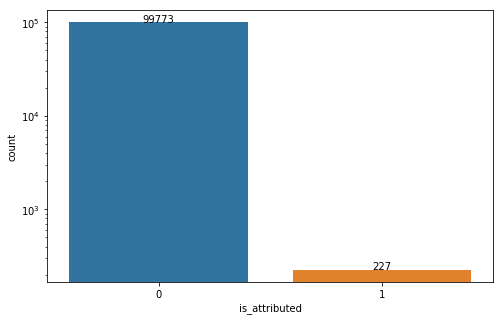

In [307]:
plt.figure(figsize=(8,5))

temp = train.groupby("is_attributed").size()
indx = temp.index
temp.reset_index(drop=True, inplace=True)
    
ax = sns.barplot(temp.index, temp.values, log=True)
ax.set_xticklabels(indx)
ax.set_xlabel("is_attributed")
ax.set_ylabel("count")

for p, count in zip(ax.patches, temp.values):
    ax.text(p.get_x() + p.get_width() / 2,
           p.get_height(),
           count,
           ha='center')

This is pretty much everything for the EDA, several findings: 
* there are major **os**, **device** types that dominate the market in China 
* there are major **ip**, probably some very big networks 
* almost all of the features are un-correlated 
* the behavior of mobil users tend to be consistent over days, there is a trend here 
* **hour** probably could be used as a new feature in next step 
* the label is highly imbalanced, probably will need some resampling techniques 

Here is plan for next step: 
* try adding **hour** and/or **day** as new features 
* delete **click_time** column to shrink data size 
* try different types of classifiers: Tree-based, ensemble, etc
* try model stacking method 